![alt text](./img/header.png)

# Exercise A: Calculation of Head and Equivalent Freshwater Head

The purpose of this exercise is to familiarize course participants with the equations for calculating head and equivalent freshwater head.  These calculations will be made for a one-dimensional hydrostatic water column that contains freshwater overlying saline water.  These are important calculations when setting up variable-density numerical models.  

In [1]:
# %load nbsetup.py
%matplotlib inline
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import flopy

<img src="./img/FreshwaterHead.png" width="400" height="500" />

*Fluid pressure at above a datum*

$P_n = \rho_n g \left( h - Z_n \right)$,

where $P_n$ is the pressure at point $n$ [ML$^{-1}$T$^{-2}$], $\rho$ is the density of water at point $n$ [ML$^{-3}$], $g$ is gravitational acceleration [LT$^{-1}$], $h$ is head [L], and $Z_n$ is the elevation of point $n$ above datum [L].

*Conversion of pressure to head in a piezometer above a datum*

$h = \frac{P_n}{\rho_n g} + Z_n$.

*Conversion of head to freshwater head*

$h_f = \frac{\rho}{\rho_f} h - \frac{\rho - \rho_f}{\rho_f} Z_n$

where $\rho_f$ is the density of freshwater [ML$^{-3}$].

*Conversion of freshwater head to head*

$h = \frac{\rho_f}{\rho} h_f + \frac{\rho - \rho_f}{\rho} Z_n$.

From [Guo and Langevin (2002)](http://fl.water.usgs.gov/PDF_files/twri_6_A7_guo_langevin.pdf).

### Functions to calculate pressure, head, and convert to and from freshwater heads

The functions below can be used to calculate the pressure at point, head at a point, convert head at a point to freshwater head at a point, and convert freshwater head at a point to head at a point.

These functions will help understand the calculations used in SEAWAT.

In [2]:
def calc_pressure(rho=1000., h=0., z=0., g=9.81):
    return rho * g * (h - z)

def calc_head(p=0., rho=1000., z=0., g=9.81):
    return (p/(rho*g)) + z

def convertto_freshwater_head(rho=1000., h=0., z=0., rhof=1000.):
    return (rho/rhof) * h - ((rho-rhof)/rhof) * z

def convertto_head(rho=1000., hf=0., z=0., rhof=1000.):
    return (rhof/rho) * hf + ((rho-rhof)/rho) * z

### Calculate the pressure, head, and equivalent head at a point

Calculate the pressure at an elevation of -5 m in a well filled with freshwater if the water level measurement is 0 m.

In [3]:
z = -5
rho = 1000.
h = 0.
p = calc_pressure(rho=rho, h=h, z=z)
print(p)

49050.0


Calculate the head using the calculated pressure

In [4]:
print(calc_head(p=p, rho=rho, z=z))

0.0


Convert the head to a freshwater head

In [5]:
hf = convertto_freshwater_head(rho=rho, h=h, z=z)
print(hf)

0.0


### Exercise 1

How would the pressure and freshwater head change if the well was filled with saltwater ($\rho$ = 1025. kgm$^{-3}$)?

In [6]:
z = -5
rho = 1025.
h = 0.
p = calc_pressure(rho=rho, h=h, z=z)
print(p)
print(calc_head(p=p, rho=rho, z=z))
hf = convertto_freshwater_head(rho=rho, h=h, z=z)
print(hf)

50276.25
0.0
0.125


### Hydrostatic pressure with depth

Hydrostatic pressure at elevation $z$ can be calculated using

$P(z) = \int_{z0}^{z} \rho(z') g dz'$,

where $z0$ is the starting elevation, $z$ is the elevation of interest, and $\rho(z')$ is the fluid density between $z0$ and $z$. 

In a variable density environment the hydrostatic pressure with depth can be calculated as

$P(z) = P(z0) + \bar{\rho}(z) g \Delta z$,

where $P(z0)$ is the pressure at $z0$, $\bar{\rho}(z')$ is the average density between $z0$ and $z$, and $\Delta z = z - z0$.

The python function below calculates a hydrostatic pressure profile using a passed numpy array of $\rho$ with depth and elevations ($z$).

In [7]:
def calc_pressure_profile(rho, z, h0=0., g=9.81):
    p = np.zeros((z.shape[0]), dtype=np.float)
    p[0] = rho[0] * g * (h0 - z[0])
    for idx in range(1, z.shape[0]):
        dz = 0.5 * (z[idx-1] - z[idx])
        p[idx] = p[idx-1] + (rho[idx-1] * dz + rho[idx] * dz) * g
    return p

### Calculate the pressure and head for a vertical profile

Calculate the pressure and head for a vertical profile of 30 cells with a $\Delta z$ = 10 m, land surface elevation (`zs`) of 0 m, saltwater occuring at and below a depth of -300 m (`zl`), and a well water level (`hw`) of 0 m. The following tasks can be thought of as representing calculation of hydrostatic conditions in a model with 30 layers, 10 m layer thicknesses, and 200 m of freshwater overlying 100 m of seawater.

Create an vector with elevations to calculate the pressure and head.

In [8]:
zs = 0.
zl = -300.
dz = 10.
z = np.arange(zs, zl, -dz) - dz/2.
print(z)

[  -5.  -15.  -25.  -35.  -45.  -55.  -65.  -75.  -85.  -95. -105. -115.
 -125. -135. -145. -155. -165. -175. -185. -195. -205. -215. -225. -235.
 -245. -255. -265. -275. -285. -295.]


Develop a distribution of fluid density (`rho`) with depth (`z`).

[ 1000.  1000.  1000.  1000.  1000.  1000.  1000.  1000.  1000.  1000.
  1000.  1000.  1000.  1000.  1000.  1000.  1000.  1000.  1000.  1000.
  1025.  1025.  1025.  1025.  1025.  1025.  1025.  1025.  1025.  1025.]


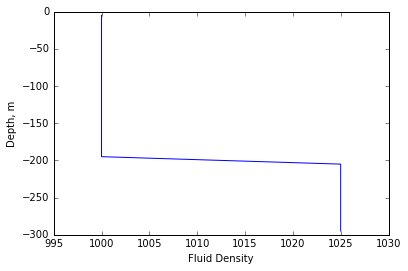

In [9]:
rho = np.ones(z.shape[0], dtype=np.float) * 1000.
rho[20:] = 1025.
plt.plot(rho, z)
plt.xlim(995, 1030)
plt.xlabel('Fluid Density')
plt.ylabel('Depth, m')
print(rho)

Calculate the pressure profile (`p`) using `rho`, `z`, and `hw`.

[   49050.     147150.     245250.     343350.     441450.     539550.
   637650.     735750.     833850.     931950.    1030050.    1128150.
  1226250.    1324350.    1422450.    1520550.    1618650.    1716750.
  1814850.    1912950.    2012276.25  2112828.75  2213381.25  2313933.75
  2414486.25  2515038.75  2615591.25  2716143.75  2816696.25  2917248.75]


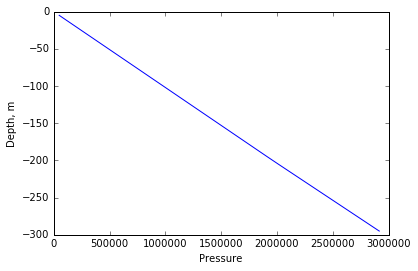

In [10]:
hw = 0.
p = calc_pressure_profile(rho=rho, z=z, h0=hw)
plt.plot(p, z)
plt.xlabel('Pressure')
plt.ylabel('Depth, m')
print(p)

Calculate the native head (`h`) with depth using `p`, `rho`, and `z`.

[ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
 -4.87804878 -4.87804878 -4.87804878 -4.87804878 -4.87804878 -4.87804878
 -4.87804878 -4.87804878 -4.87804878 -4.87804878]


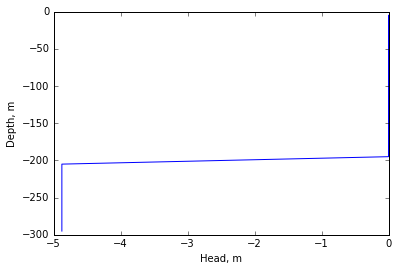

In [11]:
h = calc_head(p=p, rho=rho, z=z)
plt.plot(h, z)
plt.xlabel('Head, m')
plt.ylabel('Depth, m')
print(h)

### Exercise 2

Convert the head to freshwater head and plot the freshwater head with depth (`hf`) using `rho`, `h`, and `z`.

[ 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
  0.     0.     0.     0.     0.     0.     0.     0.     0.     0.125
  0.375  0.625  0.875  1.125  1.375  1.625  1.875  2.125  2.375]


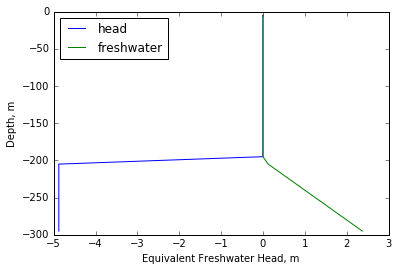

In [12]:
hf = convertto_freshwater_head(rho=rho, h=h, z=z)
plt.plot(h, z, label='head')
plt.plot(hf, z, label='freshwater')
plt.xlabel('Equivalent Freshwater Head, m')
plt.ylabel('Depth, m')
plt.legend(loc='upper left')
print(hf)

Convert the freshwater head to head and plot the native head with depth (`h`) using `rho`, `hf`, and `z`.

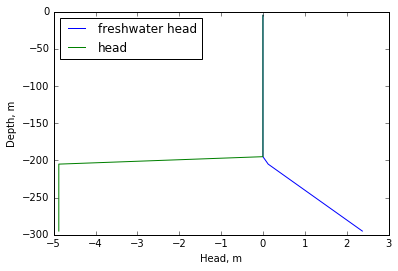

In [13]:
hh = convertto_head(rho=rho, hf=hf, z=z)
plt.plot(hf, z, label='freshwater head')
plt.plot(hh, z, label='head')
plt.legend(loc='upper left')
plt.xlabel('Head, m')
plt.ylabel('Depth, m');

### Exercise 3

Recalculate the pressure, head, and freshwater head for the case where 50 m of freshwater overlies 250 m of saltwater.

[ 1000.  1000.  1000.  1000.  1000.  1025.  1025.  1025.  1025.  1025.
  1025.  1025.  1025.  1025.  1025.  1025.  1025.  1025.  1025.  1025.
  1025.  1025.  1025.  1025.  1025.  1025.  1025.  1025.  1025.  1025.]


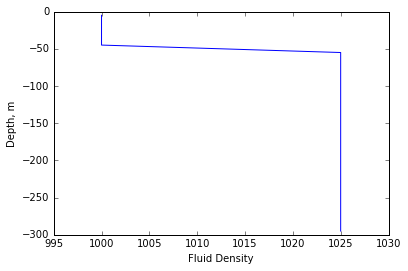

In [14]:
rho = np.ones(z.shape[0], dtype=np.float) * 1000.
rho[5:] = 1025.
plt.plot(rho, z)
plt.xlim(995, 1030)
plt.xlabel('Fluid Density')
plt.ylabel('Depth, m')
print(rho)

[   49050.     147150.     245250.     343350.     441450.     540776.25
   641328.75   741881.25   842433.75   942986.25  1043538.75  1144091.25
  1244643.75  1345196.25  1445748.75  1546301.25  1646853.75  1747406.25
  1847958.75  1948511.25  2049063.75  2149616.25  2250168.75  2350721.25
  2451273.75  2551826.25  2652378.75  2752931.25  2853483.75  2954036.25]


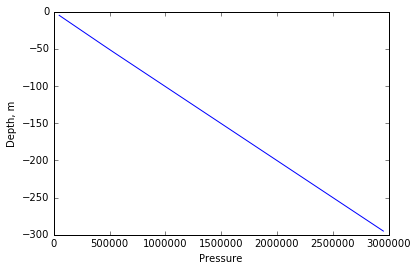

In [15]:
hw = 0.
p = calc_pressure_profile(rho=rho, z=z, h0=hw)
plt.plot(p, z)
plt.xlabel('Pressure')
plt.ylabel('Depth, m')
print(p)

[ 0.         0.         0.         0.         0.        -1.2195122
 -1.2195122 -1.2195122 -1.2195122 -1.2195122 -1.2195122 -1.2195122
 -1.2195122 -1.2195122 -1.2195122 -1.2195122 -1.2195122 -1.2195122
 -1.2195122 -1.2195122 -1.2195122 -1.2195122 -1.2195122 -1.2195122
 -1.2195122 -1.2195122 -1.2195122 -1.2195122 -1.2195122 -1.2195122]


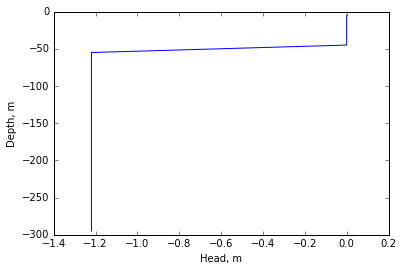

In [16]:
h = calc_head(p=p, rho=rho, z=z)
plt.plot(h, z)
plt.xlabel('Head, m')
plt.ylabel('Depth, m')
print(h)

[ 0.     0.     0.     0.     0.     0.125  0.375  0.625  0.875  1.125
  1.375  1.625  1.875  2.125  2.375  2.625  2.875  3.125  3.375  3.625
  3.875  4.125  4.375  4.625  4.875  5.125  5.375  5.625  5.875  6.125]


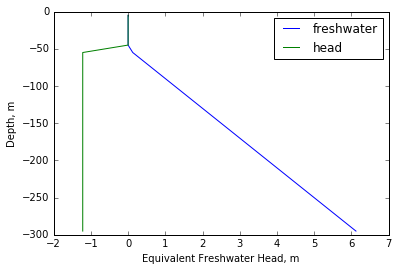

In [17]:
hf = convertto_freshwater_head(rho=rho, h=h, z=z)
plt.plot(hf, z, label='freshwater')
plt.plot(h, z, label='head')
plt.xlabel('Equivalent Freshwater Head, m')
plt.ylabel('Depth, m')
plt.legend(loc='upper right')
print(hf)